# Add skyview factor to feature set

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import os
import pyproj

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

In [2]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)


C:\Users\kasj\AppData\Local\Temp\ipykernel_23260\1073794623.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [5]:
gridded_data_dir = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/train/RGI60-08.01126/gridded_data_svf.nc'

with xr.open_dataset(gridded_data_dir) as ds_grid_out:
    ds_grid = ds_grid_out

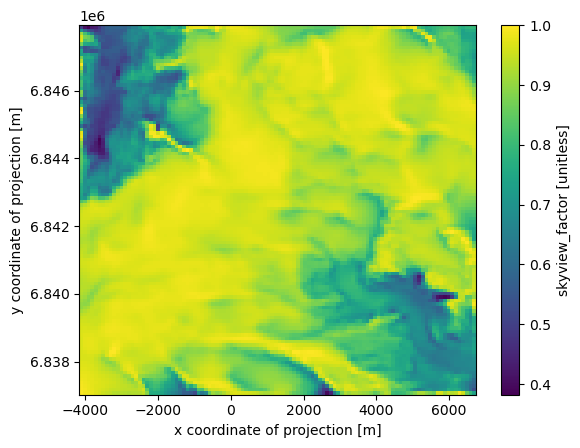

In [7]:
ds_grid.skyview_factor.plot()

In [4]:
# Function to add skyview_factor to gridded_data
def add_svf_to_gridded_data(svf_path, gridded_data_path, output_path):
    # Open SVF data
    svf_ds = xr.open_dataset(svf_path)
    svf_var = svf_ds['__xarray_dataarray_variable__']  # '__xarray_dataarray_variable__' is the default name if not specified
    
    # Rename the variable to "skyview_factor"
    svf_var = svf_var.rename("skyview_factor")

    # Open gridded data
    gridded_ds = xr.open_dataset(gridded_data_path)

    # Adjust the coordinates of svf_var to match gridded_data
    svf_var = svf_var.assign_coords({
        "x": gridded_ds.coords["x"],
        "y": gridded_ds.coords["y"]
    })

    # Merge the SVF variable into the gridded dataset
    combined_ds = gridded_ds.assign({"skyview_factor": svf_var})

    # Save the result
    combined_ds.to_netcdf(output_path)

# Main function to iterate through all subdirectories
def main(train_dir):
    for subdir in os.listdir(train_dir):
        subdir_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subdir_path) and subdir.startswith('RGI60-08'):
            svf_path = os.path.join(subdir_path, 'svf.nc')
            gridded_data_path = os.path.join(subdir_path, 'gridded_data.nc')
            output_path = os.path.join(subdir_path, 'gridded_data_svf.nc')
            if os.path.exists(svf_path) and os.path.exists(gridded_data_path):
                print(f"Processing {subdir_path}")
                add_svf_to_gridded_data(svf_path, gridded_data_path, output_path)
            else:
                print(f"Missing svf.nc or gridded_data.nc in {subdir_path}")

if __name__ == '__main__':
    train_dir = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test'
    main(train_dir)

Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.00434
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.00449
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01013
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01026
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01258
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01286
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01484
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.01598
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.02384
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.02650
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/test\RGI60-08.02916
Processing C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/

## Add skyview to feature dataset by retrieving skyview factor using lat-lon

In [5]:
# Get list of RGIIDs
rgi_id = data['RGIID'].unique().tolist()

In [7]:
rgi_id[0]

'RGI60-08.01258'

In [6]:
df_stake = data.copy()

# Variables of interest
voi = ['skyview_factor']

# Add columns to dataframe
df_stake[voi] = np.nan
df_stake

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,NaN
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,NaN
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,NaN
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,NaN
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,NaN
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,NaN
4168,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,NaN
4169,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,NaN


In [11]:
from pyproj import Proj, transform

# For each RGIID get attributes in nearest stake locations
for i in rgi_id:
    
    # Get latitutde and longtidue of stake locations for the given glacier.
    df_loc_rgiid = data.loc[data['RGIID']==i,('lat','lon')]
    
    # Get lat/lon coordinates of each stake:
    lat_stake = df_loc_rgiid.lat.values#.unique()
    lon_stake = df_loc_rgiid.lon.values#.unique()
    
    # Filepath of file: 
    filepath = 'C:/Users/kasj/ML_MB_Norway/Data/oggm_data/per_glacier/all/'+i+'/gridded_data_svf.nc'

    with xr.open_dataset(filepath) as ds:
        ds = ds.load()
       
    # Transform stake coordinates to OGGM data coordinates.
    #transf = pyproj.Transformer.from_proj(salem.wgs84, gdir.grid.proj, always_xy = True)
    #x_stake, y_stake = transf.transform(lon_stake, lat_stake)

    # Define the source projection from the dataset's coordinate system
    proj_string = ds.pyproj_srs
    target_proj = Proj(proj_string)

    # Define the target projection (WGS84)
    source_proj = Proj(proj='latlong', datum='WGS84')

    # Convert glacier coordinates to latitude and longitude
    x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
    
    # Convert selected coordinates to DataArrays. 
    da_x_stake = xr.DataArray(x_stake, dims=['location'])
    da_y_stake = xr.DataArray(y_stake, dims=['location'])
    
    # Get glacier variables at these coordinates.
    stake = ds.sel(x = da_x_stake, y = da_y_stake, method='nearest')
    
    # Get dataset of variables of interest.
    stake_var = stake[voi]
    
    # Convert dataset to dataframe.
    stake_var_df = stake_var.to_pandas()

    # Insert values for given RGIID. Values should be sorted in the order of coordinates
    # (x_stake, y_stake) and (lon_stake, lat_stake).
    df_stake.loc[df_stake['RGIID']==i, voi] = stake_var_df[voi].values


C:\Users\kasj\AppData\Local\Temp\ipykernel_23260\2300939163.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_23260\2300939163.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_23260\2300939163.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_stake, y_stake = transform(source_proj, target_proj, lon_stake, lat_stake)
C:\Users\kasj\AppData\Local\Temp\ipykernel_23260\2300939163.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj

In [12]:
df_stake

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281
4168,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281
4169,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281


In [13]:
df_stake.skyview_factor.values

array([0.7789973 , 0.79849392, 0.80350989, ..., 0.93228137, 0.93228137,
       0.93228137])

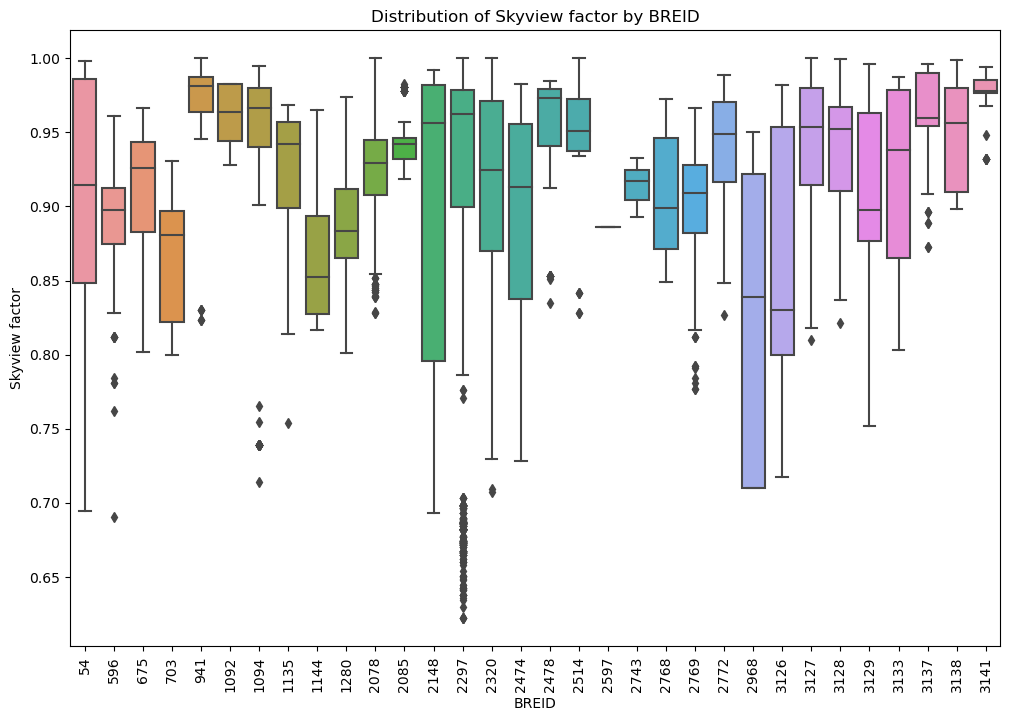

In [14]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_stake, x='BREID', y='skyview_factor')
plt.title('Distribution of Skyview factor by BREID')
plt.xlabel('BREID')
plt.ylabel('Skyview factor')
plt.xticks(rotation=90)  # Rotate x labels if there are many BREID categories
plt.show()

In [18]:
# Save dataframe
filepath = 'Data/'
filename_svf = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

df_stake.to_csv(filepath + filename_svf, index=False)  